## Posterization

In [76]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from sklearn.neighbors import NearestCentroid # Using NearestCentroid for efficient mapping
import os # Import os for file existence check

def posterize_with_palette(image, palette_rgb):
    """
    Posterizes an image using a given color palette.

    Args:
        image (PIL.Image.Image): The input image (preferably in RGB mode).
        palette_rgb (list): A list of RGB color tuples (0-255) representing the palette.

    Returns:
        PIL.Image.Image: The posterized image in RGB mode, or None if an error occurs.
    """
    if not palette_rgb:
        print("Error: Provided palette is empty.")
        return None

    try:
        # Ensure image is in RGB mode
        img_rgb = image.convert('RGB')
        img_array = np.array(img_rgb)
        original_dimensions = img_array.shape[:2] # (height, width)

        # Convert original image pixels to CIELAB
        pixels_lab_original = color.rgb2lab(img_array / 255.0).reshape(-1, 3)

        # Convert the palette colors to CIELAB
        palette_lab = color.rgb2lab(np.array(palette_rgb) / 255.0)

        # Use NearestCentroid to find the closest palette color in CIELAB for each pixel
        # We fit NearestCentroid with the palette colors as features and their indices as labels
        clf = NearestCentroid()
        clf.fit(palette_lab, np.arange(len(palette_lab)))

        # Predict the index of the closest palette color for each original pixel
        closest_palette_indices = clf.predict(pixels_lab_original)

        # Create the posterized image array
        posterized_img_array = np.zeros_like(img_array)
        pixel_index = 0
        for i in range(original_dimensions[0]): # Height
            for j in range(original_dimensions[1]): # Width
                palette_index = closest_palette_indices[pixel_index]
                posterized_img_array[i, j, :] = palette_rgb[palette_index]
                pixel_index += 1

        # Convert the NumPy array back to a Pillow Image
        posterized_img = Image.fromarray(posterized_img_array, 'RGB')

        return posterized_img

    except Exception as e:
        print(f"An error occurred during posterization: {e}")
        return None

## Octree, Median Cut and MaxCoverage

In [77]:
from PIL import Image

import os

import matplotlib.pyplot as plt

import numpy as np


def quantize_image(image_path, num_colors, method):

    """

    Quantizes an image using a specified method to a specified number of colors.


    Args:

        image_path (str): The path to the input image file.

        num_colors (int): The desired number of colors in the quantized image (max 256).

        method: The quantization method to use (e.g., Image.Quantize.FASTOCTREE).


    Returns:

        PIL.Image.Image: The quantized image in 'P' mode (paletted), or None if an error occurs.

    """

    if not 2 <= num_colors <= 256:

        print("Error: Number of colors must be between 2 and 256 for paletted images.")

        return None


    if not os.path.exists(image_path):

        print(f"Error: Image file not found at {image_path}")

        return None


    try:

        # Open the image

        img = Image.open(image_path)


        # Ensure the image is in a suitable mode (e.g., RGB) before quantizing

        # Convert to RGB if not already to handle potential alpha channels etc.

        if img.mode != 'RGB':

            print(f"  Converting image from {img.mode} to RGB...")

            #img = img.convert('RGB')

            img = Image.open(image_path)

            arr = np.array(img)

            alpha_mask = arr[..., 3] > 0

            img = arr[alpha_mask, :3]

            img = Image.fromarray(img, 'RGBA')

           


        # Perform color quantization with the specified method

        print(f"  Quantizing image to {num_colors} colors using {method.name}...")

        quantized_img = img.quantize(colors=num_colors, method=method)

        print("  Quantization complete.")


        return quantized_img


    except Exception as e:

        print(f"  An error occurred during quantization with {method.name}: {e}")

        return None


def display_palette(quantized_image, num_colors, method_name):

    """Displays the color palette of a quantized image."""

    if quantized_image is None:

        return


    try:

        palette = quantized_image.getpalette()

        colors_rgb = []

        for i in range(num_colors):

             r = palette[i * 3]

             g = palette[i * 3 + 1]

             b = palette[i * 3 + 2]

             colors_rgb.append((r, g, b))


        colors_normalized = np.array(colors_rgb) / 255.0


        fig, ax = plt.subplots(1, 1, figsize=(num_colors * 0.5, 2))

        ax.imshow([colors_normalized], aspect='auto')

        ax.set_xticks([])

        ax.set_yticks([])

        ax.set_title(f'Palette for {method_name} ({len(colors_rgb)} colors)')

        plt.show()

    except Exception as e:

        print(f"Error displaying palette for {method_name}: {e}") 

Original Image:


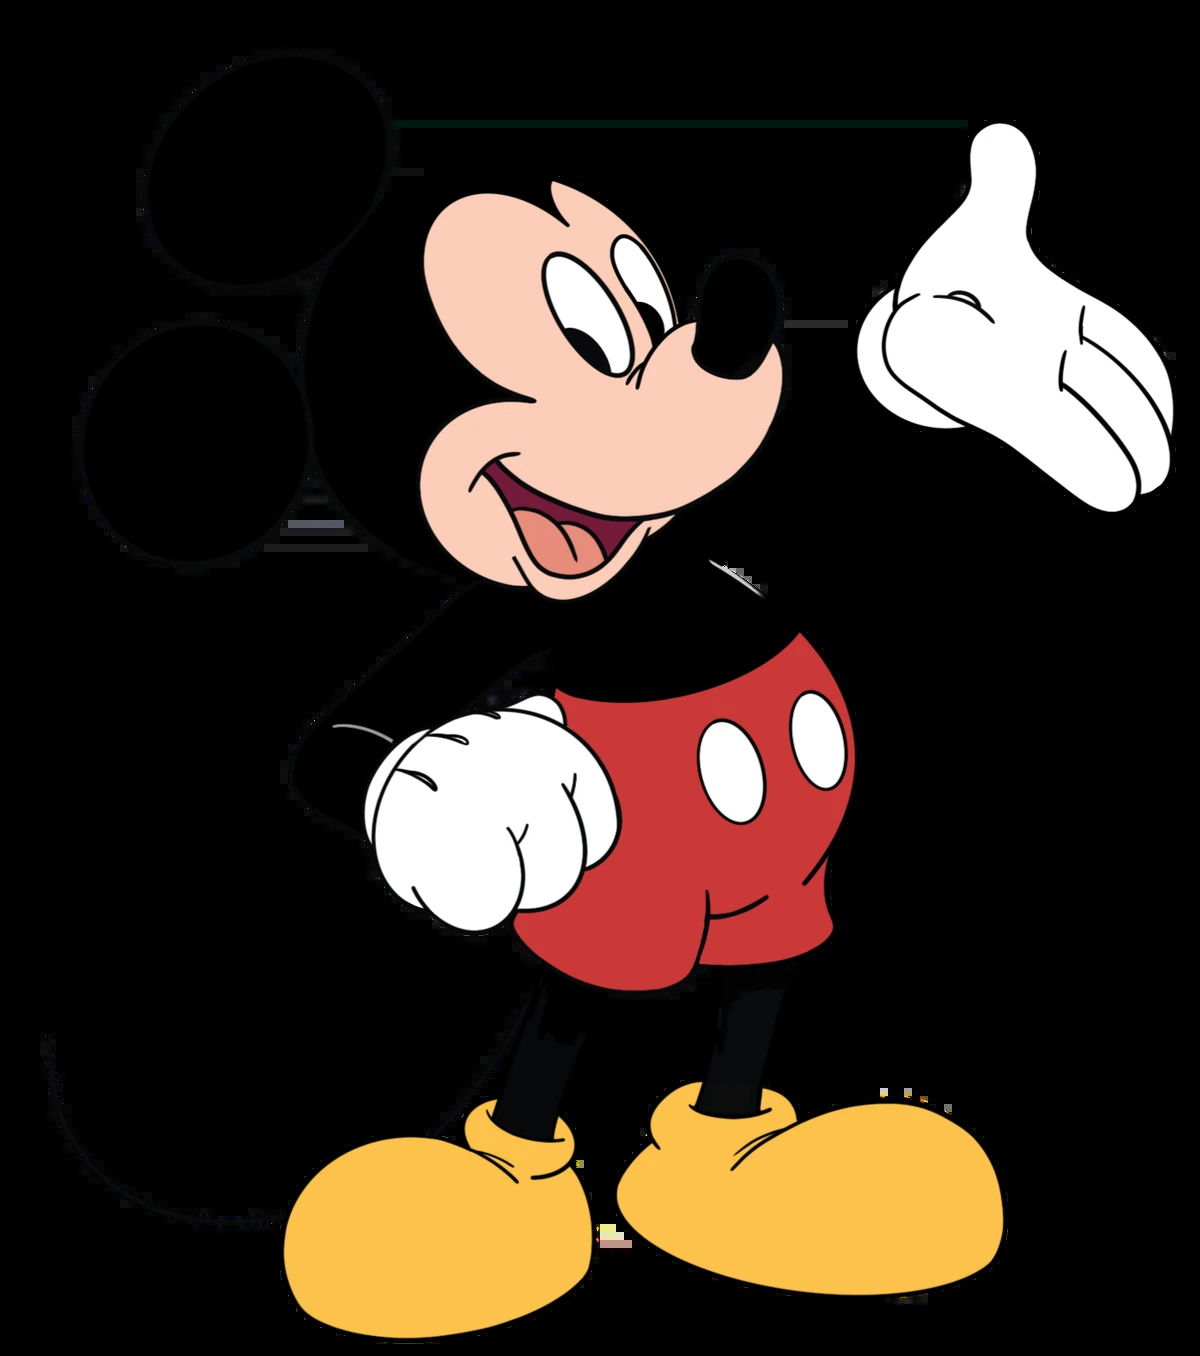


--- Results for Median Cut ---
  Converting image from RGBA to RGB...
  An error occurred during quantization with MEDIANCUT: buffer is not large enough
  Quantization failed for Median Cut.

--- Results for Maximum Coverage ---
  Converting image from RGBA to RGB...
  An error occurred during quantization with MAXCOVERAGE: buffer is not large enough
  Quantization failed for Maximum Coverage.

--- Results for Fast Octree ---
  Converting image from RGBA to RGB...
  An error occurred during quantization with FASTOCTREE: buffer is not large enough
  Quantization failed for Fast Octree.

--- Comparison Complete ---


In [103]:
# --- User Input ---

input_image_path = "mickey.png" # <--- Change this to your image file path

desired_colors = 7 # <--- Change this to the desired number of colors (2-256)

# ------------------


# Define the quantization methods to iterate through

quantization_methods = {

    "Median Cut": Image.Quantize.MEDIANCUT,

    "Maximum Coverage": Image.Quantize.MAXCOVERAGE,

    "Fast Octree": Image.Quantize.FASTOCTREE

}


# Check if the input image file exists

if not os.path.exists(input_image_path):

    print(f"Error: Input image file not found at {input_image_path}")

else:

    # Open and display the original image first

    print("Original Image:")

    original_img = Image.open(input_image_path).convert('RGB') # Ensure original is in RGB

    display(original_img)


    # Iterate through each quantization method

    for method_name, method_value in quantization_methods.items():

        print(f"\n--- Results for {method_name} ---")


        # Quantize the image using the current method (creates a paletted image)

        quantized_image = quantize_image(input_image_path, desired_colors, method_value)


        if quantized_image:

            # Display the quantized image

            print(f"Quantized Image ({method_name}):")

            display(quantized_image)


            # *** CORRECTED PART: Extract the palette from the quantized image ***

            try:

                # Get the flat palette list (768 values)

                flat_palette = quantized_image.getpalette()


                # Convert the flat palette list to a list of RGB tuples (0-255)

                extracted_palette_rgb = []

                # The palette list has 768 entries (256 colors * 3 channels).

                # We need to extract the first `desired_colors` entries as RGB tuples.

                for i in range(desired_colors):

                    r = flat_palette[i * 3]

                    g = flat_palette[i * 3 + 1]

                    b = flat_palette[i * 3 + 2]

                    extracted_palette_rgb.append((r, g, b))


                # Display the extracted color palette visually

                display_palette(quantized_image, desired_colors, method_name) # This function still just displays


                # Now pass the correctly extracted palette to the posterize function

                print("\nPosterizing original image using the extracted palette:")

                posterized_image = posterize_with_palette(original_img, extracted_palette_rgb)

                display(posterized_image)



            except Exception as e:

                 print(f"An error occurred while processing palette or posterizing for {method_name}: {e}")


        else:

            print(f"  Quantization failed for {method_name}.")


    print("\n--- Comparison Complete ---") 

## K-means

Original Image:


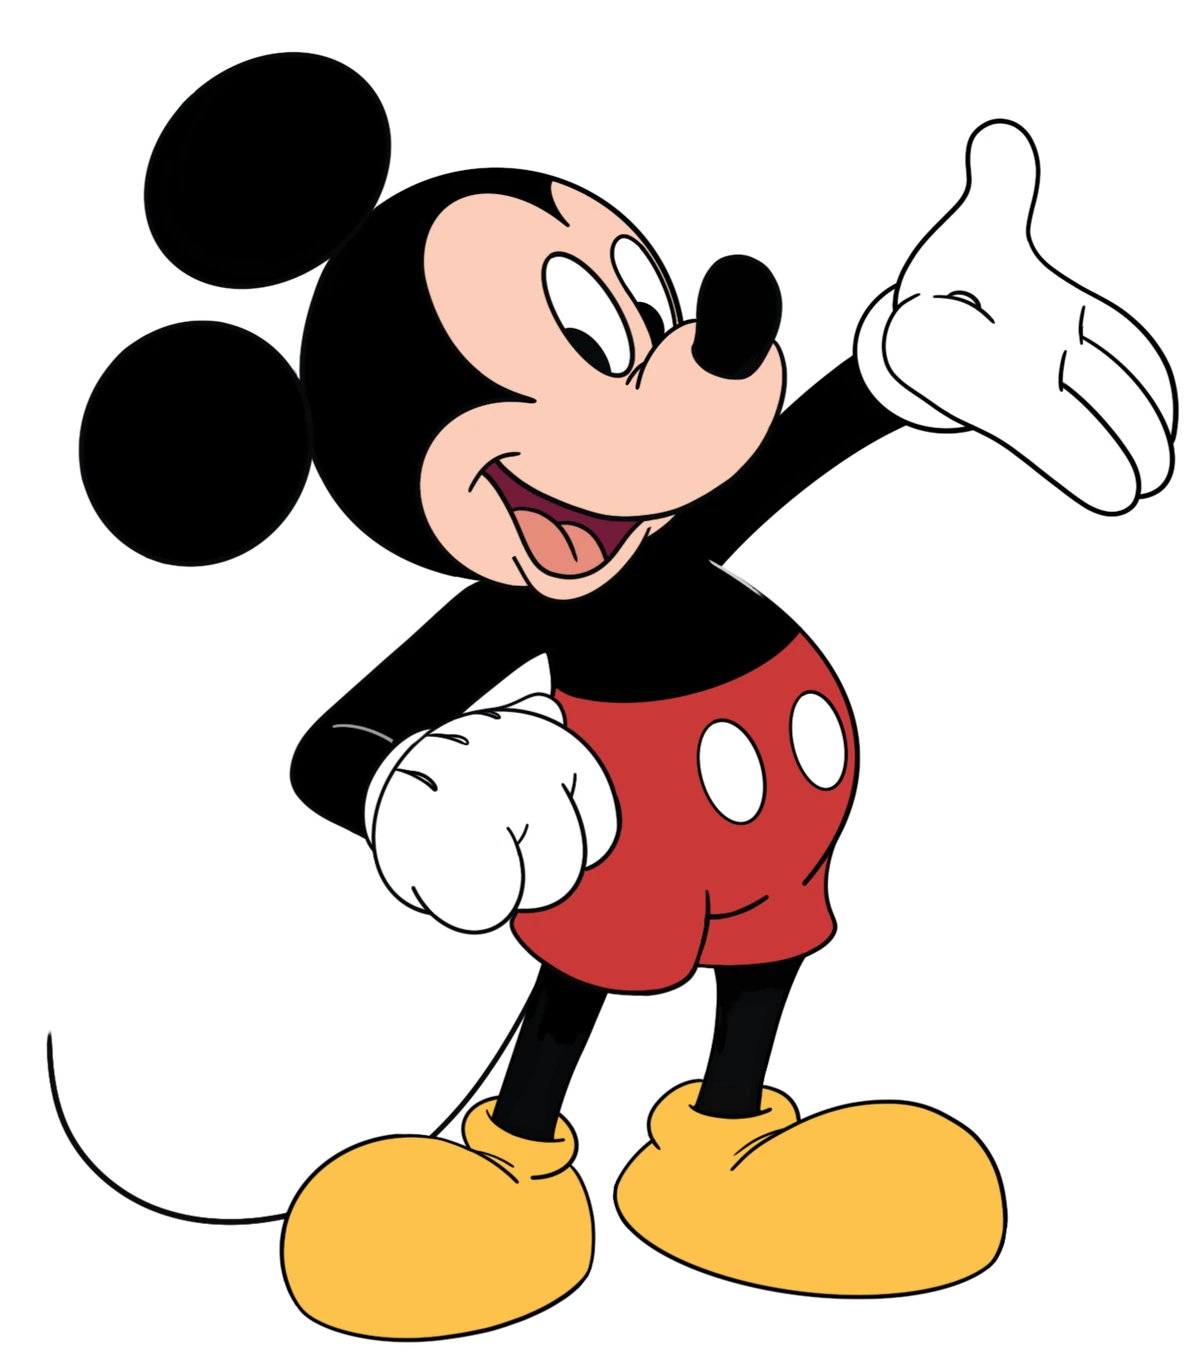

Performing K-Means clustering in CIELAB with 7 clusters...
Clustering complete.

Quantized Image (CIELAB K-Means):


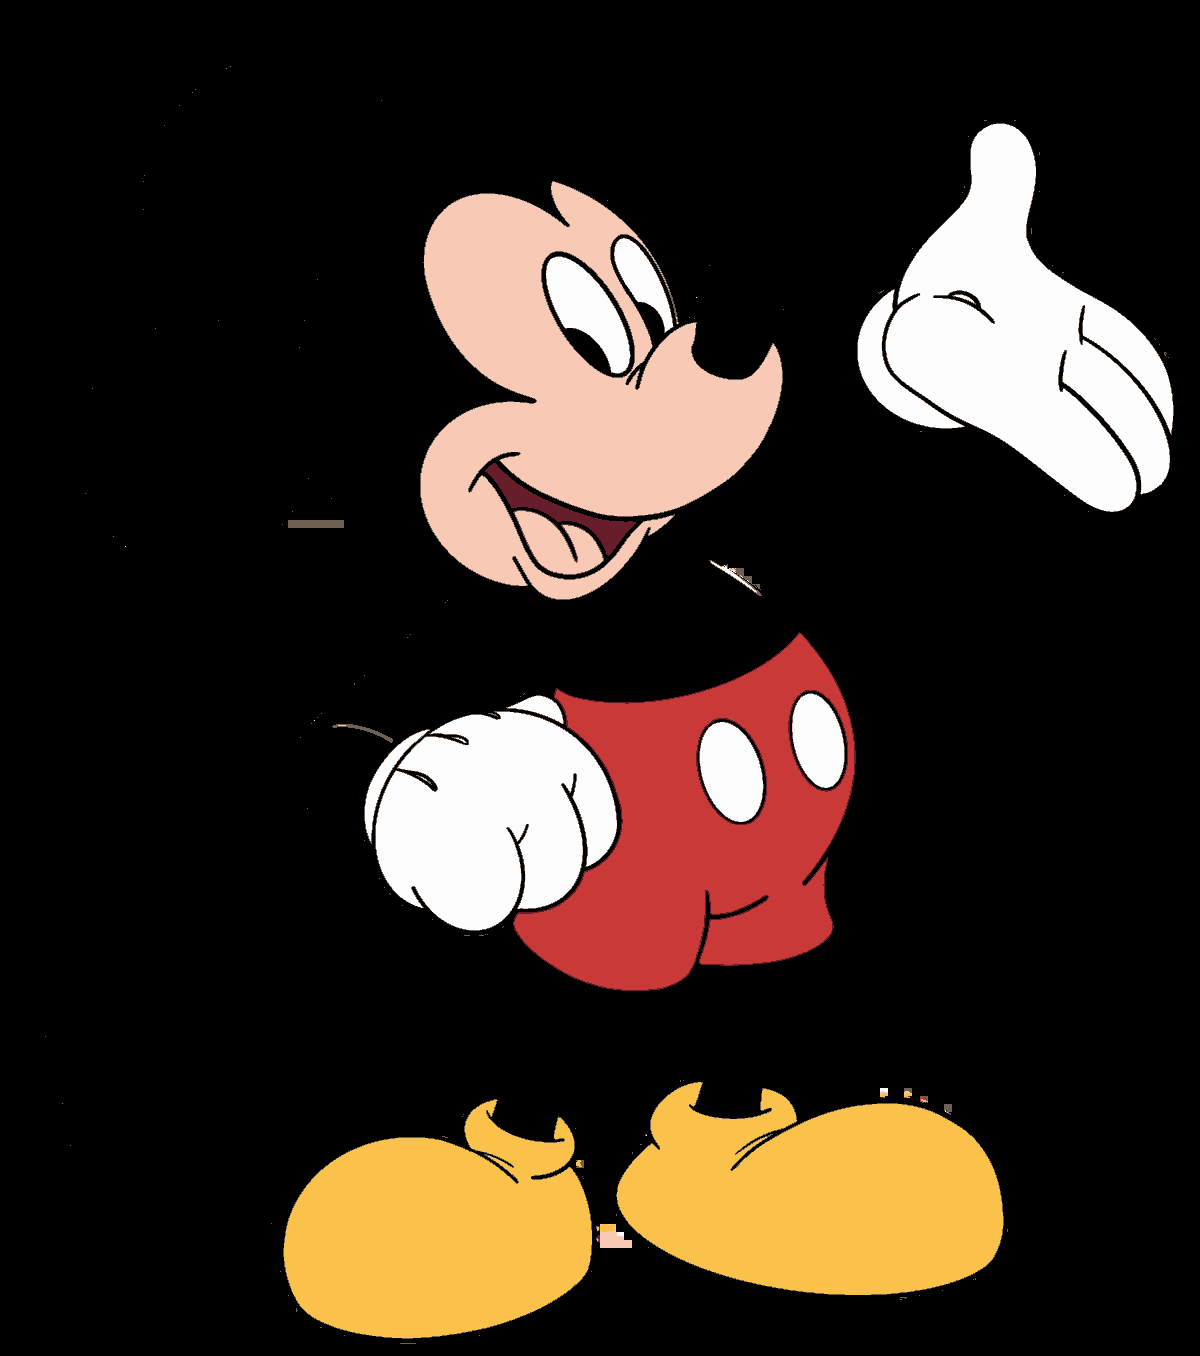

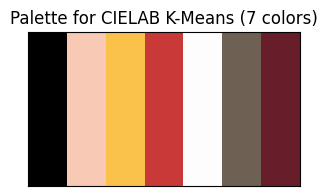


Posterizing original image using the extracted palette:


C:\Users\adamk\AppData\Roaming\Python\Python313\site-packages\sklearn\neighbors\_nearest_centroid.py:241: RuntimeWarning: invalid value encountered in divide
  np.sqrt(variance.sum(axis=0) / (n_samples - n_classes)), copy=False


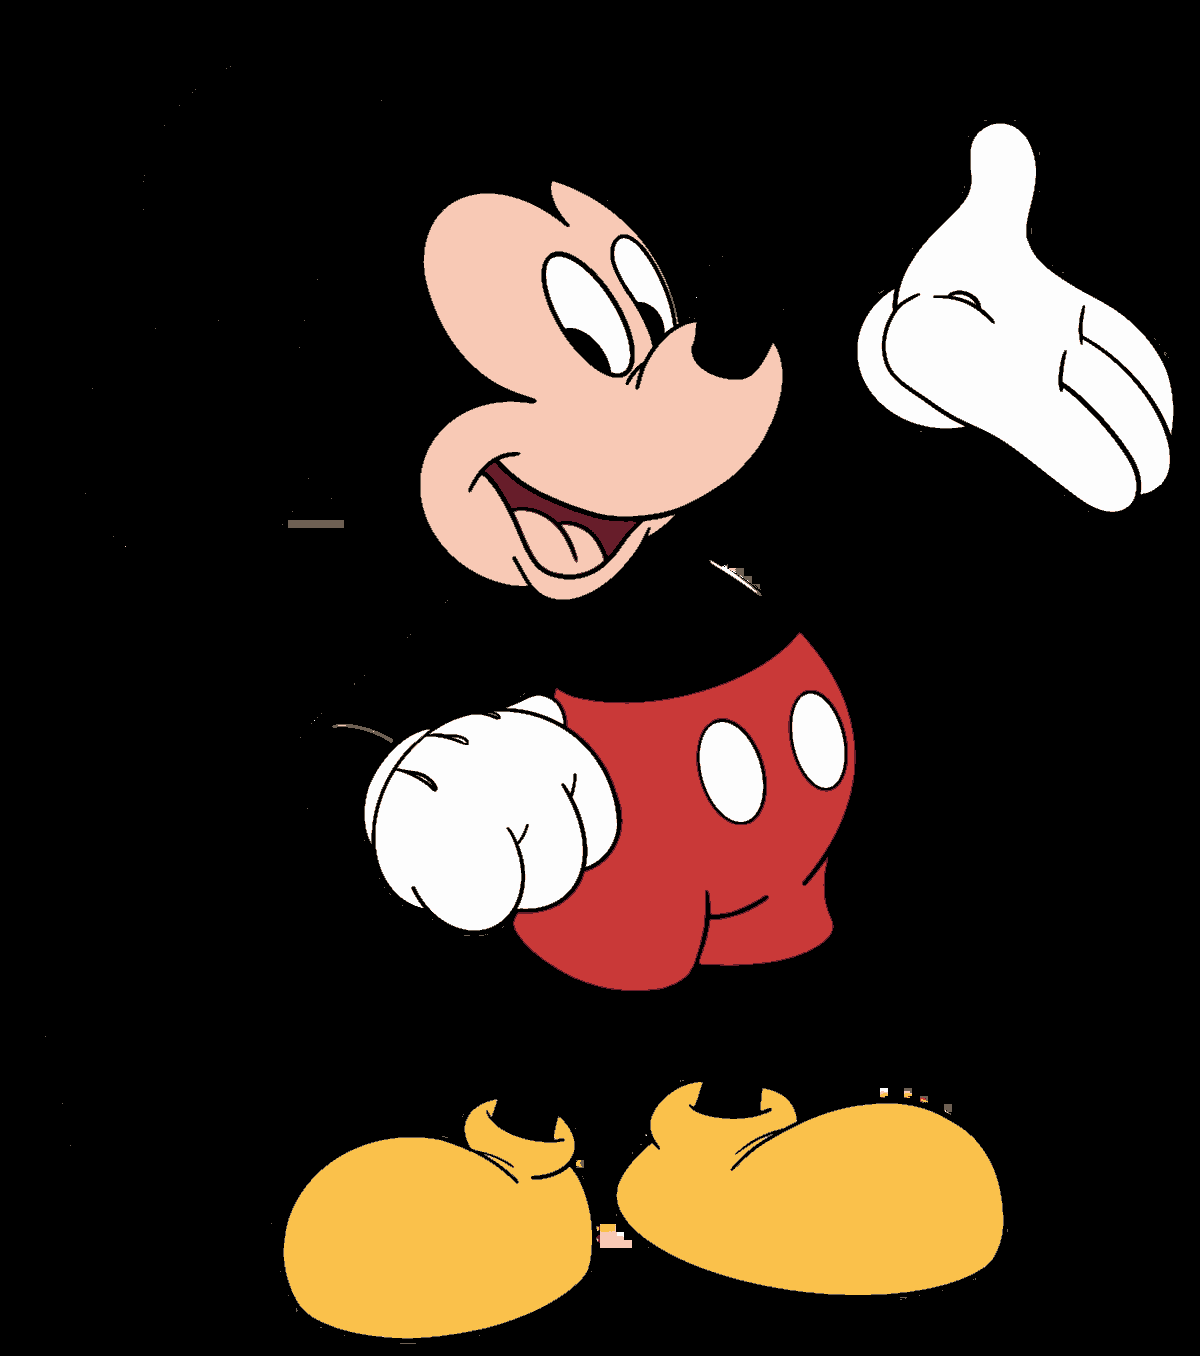

In [104]:
from skimage import color # Use skimage for color space conversion
from sklearn.cluster import KMeans # Use scikit-learn for K-Means clustering

def quantize_image_cielab(image_path, num_colors):
    """
    Quantizes an image using K-Means clustering in the CIELAB color space.

    Args:
        image_path (str): The path to the input image file.
        num_colors (int): The desired number of colors in the quantized image.

    Returns:
        tuple: A tuple containing:
            - PIL.Image.Image: The quantized image in 'RGB' mode.
            - list: The color palette as a list of RGB tuples (0-255), or None if an error occurs.
    """
    if not os.path.exists(image_path):
        print(f"Error: Image file not found at {image_path}")
        return None, None

    try:
        # Open the image and convert to RGB
        img = Image.open(image_path).convert('RGB')
        img_array = np.array(img)

        # Convert RGB to CIELAB
        # skimage expects float in range [0, 1] for RGB to Lab conversion
        img_lab = color.rgb2lab(img_array / 255.0)

        # Reshape the CIELAB image data into a list of pixels
        pixels_lab = img_lab.reshape(-1, 3)

        # Apply K-Means clustering to the CIELAB pixels
        print(f"Performing K-Means clustering in CIELAB with {num_colors} clusters...")
        kmeans = KMeans(n_clusters=num_colors, random_state=42, n_init=10) # n_init to avoid local minima
        kmeans.fit(pixels_lab)
        print("Clustering complete.")

        # Get the cluster centers (the quantized colors in CIELAB)
        new_colors_lab = kmeans.cluster_centers_

        # Convert the CIELAB cluster centers back to RGB (0-1 range)
        new_colors_rgb_normalized = color.lab2rgb(new_colors_lab)

        # Convert RGB colors back to 0-255 range for the palette
        palette_rgb = (new_colors_rgb_normalized * 255).astype(np.uint8).tolist()

        # Create the quantized image using the cluster labels
        labels = kmeans.labels_
        quantized_img_array = np.zeros_like(img_array)
        pixel_index = 0
        for i in range(img_array.shape[0]):
            for j in range(img_array.shape[1]):
                # Assign the RGB color of the cluster center to each pixel
                quantized_img_array[i, j, :] = palette_rgb[labels[pixel_index]]
                pixel_index += 1

        # Convert the quantized NumPy array back to a Pillow Image
        quantized_img = Image.fromarray(quantized_img_array, 'RGB')

        return quantized_img, palette_rgb

    except Exception as e:
        print(f"An error occurred during CIELAB quantization: {e}")
        return None, None

def display_rgb_palette(palette_rgb, method_name="CIELAB K-Means"):
    """Displays a color palette from a list of RGB tuples."""
    if palette_rgb is None:
        return

    try:
        # Convert RGB values to a format suitable for Matplotlib (0-1 range)
        colors_normalized = np.array(palette_rgb) / 255.0

        fig, ax = plt.subplots(1, 1, figsize=(len(palette_rgb) * 0.5, 2))
        ax.imshow([colors_normalized], aspect='auto')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Palette for {method_name} ({len(palette_rgb)} colors)')
        plt.show()
    except Exception as e:
        print(f"Error displaying palette for {method_name}: {e}")

# Check if the input image file exists
if not os.path.exists(input_image_path):
    print(f"Error: Input image file not found at {input_image_path}")
else:
    # Open and display the original image first
    print("Original Image:")
    original_img = Image.open(input_image_path)
    display(original_img)

    # Perform CIELAB quantization
    quantized_image_cielab, palette_km = quantize_image_cielab(input_image_path, desired_colors)

    if quantized_image_cielab:
        # Display the quantized image
        print("\nQuantized Image (CIELAB K-Means):")
        display(quantized_image_cielab)

        # Display the color palette
        display_rgb_palette(palette_km)


        # Now pass the correctly extracted palette to the posterize function
        print("\nPosterizing original image using the extracted palette:")
        posterized_image_km = posterize_with_palette(original_img, palette_km)
        display(posterized_image_km)

        # Optionally, save the quantized image
        #output_image_path_cielab = f"quantized_cielab_kmeans_{desired_colors}_colors.png"
        #try:
        #    quantized_image_cielab.save(output_image_path_cielab)
        #    print(f"\nQuantized image saved to {output_image_path_cielab}")
        #except Exception as e:
        #    print(f"  Error saving quantized image: {e}")
    else:
        print("\nCIELAB quantization failed.")

## Meanshift

In [82]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from sklearn.cluster import MeanShift, KMeans, estimate_bandwidth
from sklearn.neighbors import NearestNeighbors

# Helper to display an RGB palette
def display_rgb_palette(palette_rgb, title="Color Palette"):
    if not palette_rgb:
        print("No palette to display.")
        return
    colors = np.array(palette_rgb) / 255.0
    fig, ax = plt.subplots(1, 1, figsize=(len(palette_rgb)*0.5, 2))
    ax.imshow([colors], aspect='auto')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f'{title} ({len(palette_rgb)} colors)')
    plt.show()

# Function to reduce a CIELAB palette via K‑Means
def reduce_palette_kmeans(initial_palette_lab, target_colors):
    if initial_palette_lab is None or len(initial_palette_lab) <= target_colors:
        return initial_palette_lab
    kmeans = KMeans(n_clusters=target_colors, random_state=42, n_init=10)
    kmeans.fit(initial_palette_lab)
    return kmeans.cluster_centers_

# ——————————————— User Inputs ———————————————
input_image_path        = "mickey.png"
downsample_factor       = 0.25    # fraction of original dimensions to process
bandwidth_quantile      = 0.2 # lower is more colors higher is less
bandwidth_percent_samples  = 20
desired_final_colors    = 8
# —————————————————————————————————————————————

if not os.path.exists(input_image_path):
    raise FileNotFoundError(f"'{input_image_path}' not found")

# 1) Load full‑res image
orig_img = Image.open(input_image_path).convert('RGB')
orig_w, orig_h = orig_img.size
orig_array = np.array(orig_img)
orig_lab   = color.rgb2lab(orig_array / 255.0)

print(f"Original size: {orig_w}×{orig_h}")

# 2) Downsample for bandwidth estimation & MS clustering
ds_w = max(1, int(orig_w * downsample_factor))
ds_h = max(1, int(orig_h * downsample_factor))
ds_img = orig_img.resize((ds_w, ds_h), resample=Image.LANCZOS)
ds_array = np.array(ds_img)
ds_lab   = color.rgb2lab(ds_array / 255.0)
pixels_ds = ds_lab.reshape(-1, 3)

bandwidth_n_samples = int(ds_w * ds_h * (bandwidth_percent_samples/100))
print("bandwidth_n_samples: ", bandwidth_n_samples);
print(f"Downsampled to {ds_w}×{ds_h} ({pixels_ds.shape[0]} pixels)")

# 3) Estimate bandwidth on a (random) subset
print("Estimating bandwidth…")
bw = estimate_bandwidth(
    pixels_ds, quantile=bandwidth_quantile,
    n_samples=bandwidth_n_samples, random_state=42)
print(f" -> bandwidth = {bw:.3f}")

# 4) Fit MeanShift on downsampled pixels
print("Fitting MeanShift…")
ms = MeanShift(bandwidth=bw, cluster_all=False, n_jobs=-1)
ms.fit(pixels_ds)
initial_palette_lab = ms.cluster_centers_
print(f"Found {len(initial_palette_lab)} MS clusters")

# 5) Reduce palette via K‑Means
print(f"Reducing palette to {desired_final_colors} colors…")
reduced_palette_lab = reduce_palette_kmeans(initial_palette_lab, desired_final_colors)

# Convert reduced CIELAB → RGB
# skimage.color.lab2rgb expects shape (...,3)
lab_for_conv = reduced_palette_lab.reshape(1, -1, 3)
reduced_palette_rgb = (
    color.lab2rgb(lab_for_conv)[0] * 255
).astype(np.uint8).tolist()

# 6) Reconstruct full‑res image by nearest‑neighbor lookup
print("Reconstructing full-resolution image…")
pixels_orig = orig_lab.reshape(-1, 3)

nn = NearestNeighbors(n_neighbors=1).fit(reduced_palette_lab)
_, idx = nn.kneighbors(pixels_orig)

quant_array = np.array(reduced_palette_rgb, dtype=np.uint8)[idx.flatten()]
quant_array = quant_array.reshape(orig_h, orig_w, 3)

quant_img = Image.fromarray(quant_array, 'RGB')

# 7) Display results
print("\nQuantized Image:")
display(quant_img)

print("\nFinal Reduced Palette:")
display_rgb_palette(reduced_palette_rgb, title="Reduced Palette")

# Now pass the correctly extracted palette to the posterize function
print("\nPosterizing original image using the extracted palette:")
posterized_image_ms = posterize_with_palette(original_img, reduced_palette_rgb)
display(posterized_image_ms)


Original size: 1200×1356
bandwidth_n_samples:  20340
Downsampled to 300×339 (101700 pixels)
Estimating bandwidth…
 -> bandwidth = 17.257
Fitting MeanShift…


KeyboardInterrupt: 

## Median Filtering

In [105]:
from PIL import Image, ImageFilter
from sklearn.neighbors import NearestCentroid

def apply_median_filter_and_remap(image, size, original_palette_rgb):
    """
    Applies a median filter to an image and then remaps colors to the original palette.
    Prints the number of unique colors before and after the process.

    Args:
        image (PIL.Image.Image): The input image (preferably in RGB mode, expected to have limited colors).
        size (int): The size of the median filter kernel (e.g., 3 for 3x3).
        original_palette_rgb (list): The list of RGB color tuples (0-255) from the original limited palette.

    Returns:
        PIL.Image.Image: The median-filtered and remapped image in RGB mode, or None if an error occurs.
    """
    if not original_palette_rgb:
        print("Error: Original palette is empty.")
        return None

    try:
        # Ensure image is in RGB mode and convert to numpy array
        img_rgb = image.convert('RGB')
        img_array = np.array(img_rgb)

        # --- Count unique colors BEFORE filtering ---
        unique_colors_before = len(set(tuple(p) for row in img_array for p in row))
        print(f"Unique colors BEFORE median filtering and remapping: {unique_colors_before}")
        # ------------------------------------------

        # --- Apply the median filter ---
        print(f"Applying median filter with size {size}...")
        filtered_image = img_rgb.filter(ImageFilter.MedianFilter(size=size))
        filtered_img_array = np.array(filtered_image)
        print("Median filtering complete.")
        # -------------------------------

        # --- Remap colors to the original palette ---
        print("Remapping colors to the original palette...")

        # Convert filtered image pixels to CIELAB
        filtered_pixels_lab = color.rgb2lab(filtered_img_array / 255.0).reshape(-1, 3)

        # Convert the original palette colors to CIELAB
        original_palette_lab = color.rgb2lab(np.array(original_palette_rgb) / 255.0)

        # Use NearestCentroid to find the closest palette color in CIELAB for each filtered pixel
        clf = NearestCentroid()
        clf.fit(original_palette_lab, np.arange(len(original_palette_lab)))

        # Predict the index of the closest palette color for each filtered pixel
        closest_palette_indices = clf.predict(filtered_pixels_lab)

        # Create the remapped image array
        remapped_img_array = np.zeros_like(img_array)
        original_dimensions = img_array.shape[:2] # (height, width)
        pixel_index = 0
        for i in range(original_dimensions[0]): # Height
            for j in range(original_dimensions[1]): # Width
                palette_index = closest_palette_indices[pixel_index]
                remapped_img_array[i, j, :] = original_palette_rgb[palette_index]
                pixel_index += 1
        print("Color remapping complete.")
        # -------------------------------------------

        # --- Count unique colors AFTER remapping ---
        unique_colors_after = len(set(tuple(p) for row in remapped_img_array for p in row))
        print(f"Unique colors AFTER median filtering and remapping: {unique_colors_after}")
        # -----------------------------------------


        # Convert the remapped NumPy array back to a Pillow Image
        remapped_image = Image.fromarray(remapped_img_array, 'RGB')

        return remapped_image

    except Exception as e:
        print(f"An error occurred during median filtering and remapping: {e}")
        return None

Unique colors BEFORE median filtering and remapping: 7
Applying median filter with size 1...
Median filtering complete.
Remapping colors to the original palette...


C:\Users\adamk\AppData\Roaming\Python\Python313\site-packages\sklearn\neighbors\_nearest_centroid.py:241: RuntimeWarning: invalid value encountered in divide
  np.sqrt(variance.sum(axis=0) / (n_samples - n_classes)), copy=False


Color remapping complete.
Unique colors AFTER median filtering and remapping: 7
Median filtering complete.

Original Posterized Image:


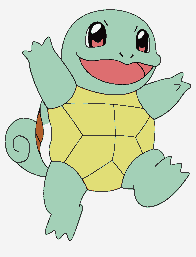


Median Filtered Image (size=1):


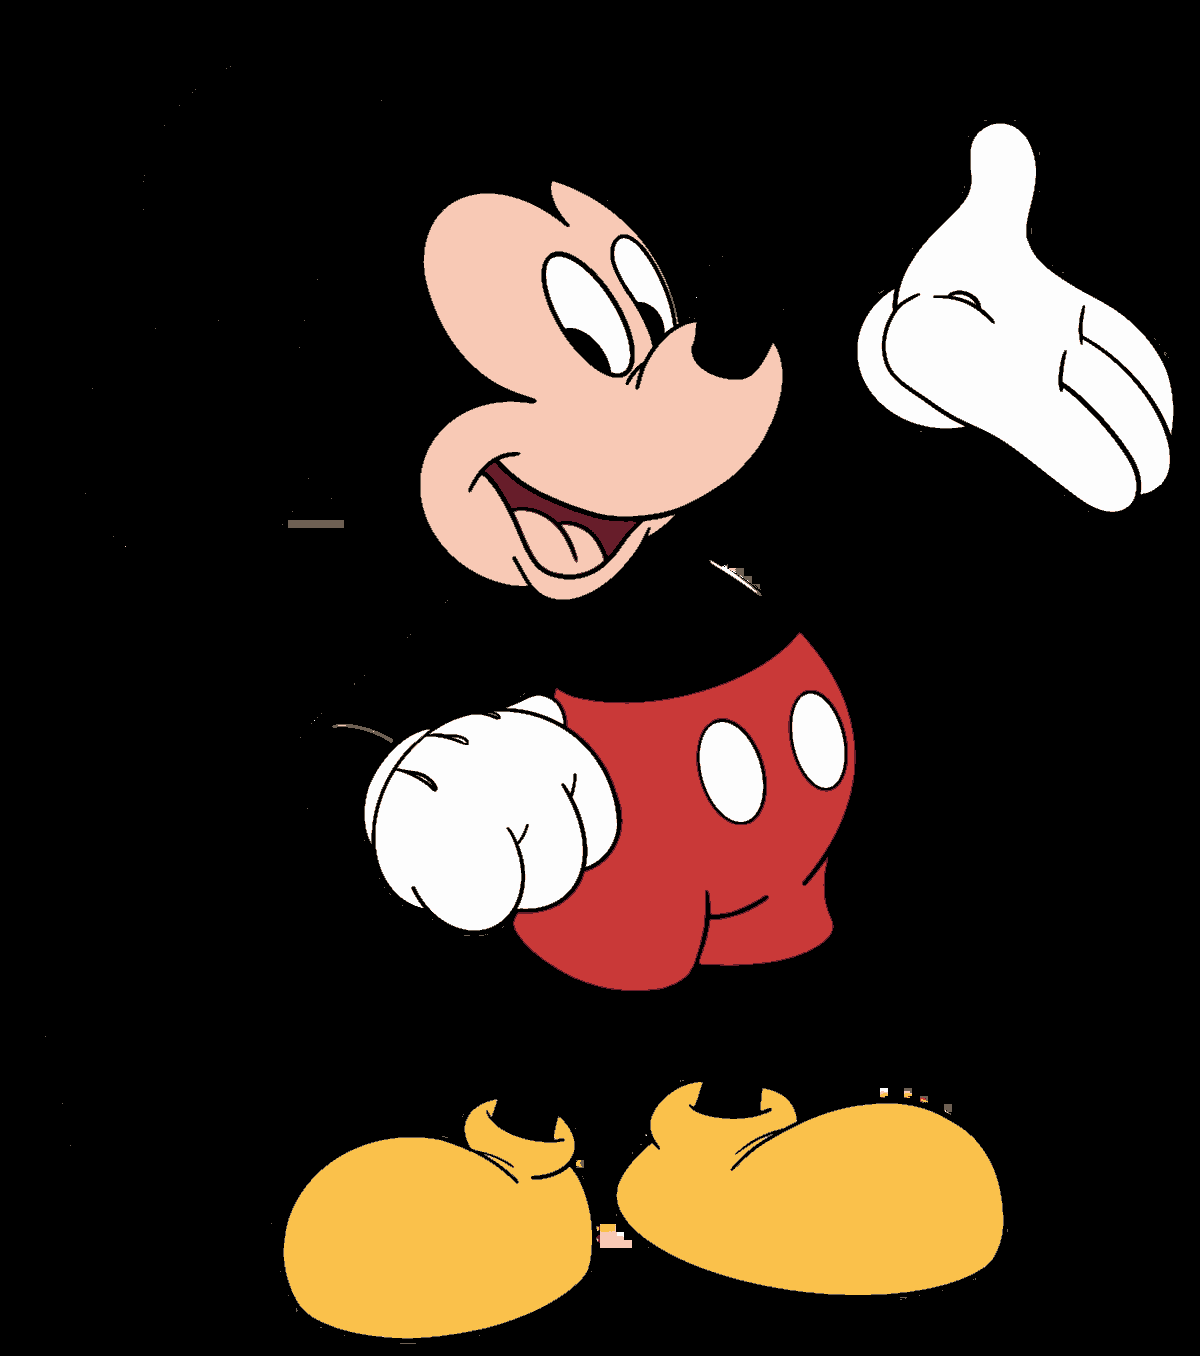

In [106]:
# --- User Input ---
median_filter_size = 1 # <--- Adjust the size of the median filter kernel (e.g., 3, 5)
# ------------------


# Apply the median filter
median_filtered_image = apply_median_filter_and_remap(posterized_image_km, median_filter_size, palette_km)

if median_filtered_image:
    print("Median filtering complete.")
    print("\nOriginal Posterized Image:")
    display(posterized_image_ms)

    print(f"\nMedian Filtered Image (size={median_filter_size}):")
    display(median_filtered_image)

        

## Minority Pixel Removal and Area Thresholding

In [107]:
from skimage.measure import label, regionprops # Import label and regionprops
from collections import Counter # To count neighboring colors
import numpy as np # Import numpy
from PIL import Image # Import Pillow Image

def remove_minority_pixels(image, area_threshold):
    """
    Removes connected components of pixels with an area below a threshold,
    replacing them with the color of the largest neighboring component.
    This version refines neighbor counting and explicitly handles border pixels
    by checking neighbor bounds.

    Args:
        image (PIL.Image.Image): The input image (preferably in RGB mode),
                                 expected to have a limited number of colors (e.g., after posterization).
        area_threshold (int): The minimum area (number of pixels) for a color region to be kept.

    Returns:
        PIL.Image.Image: The image with minority pixels removed, or None if an error occurs.
    """
    try:
        # Ensure image is in RGB mode and convert to numpy array
        img_rgb = image.convert('RGB')
        img_array = np.array(img_rgb)
        img_height, img_width = img_array.shape[:2]

        # Get unique colors and create a mapping from RGB tuple to integer ID
        # This is necessary because skimage.measure.label works on integer arrays
        unique_colors_rgb = list(set(tuple(p) for row in img_array for p in row))
        print(f"Unique colors found: {len(unique_colors_rgb)}")
        rgb_to_id = {color: i + 1 for i, color in enumerate(unique_colors_rgb)} # Use 1-based indexing for labels
        id_to_rgb = {i + 1: color for i, color in enumerate(unique_colors_rgb)}

        # Create an integer-labeled image based on color IDs
        labeled_img_id = np.zeros((img_height, img_width), dtype=int)
        for i in range(img_height):
            for j in range(img_width):
                labeled_img_id[i, j] = rgb_to_id[tuple(img_array[i, j])]

        # Perform connected component labeling
        # connectivity=2 considers diagonal neighbors as connected
        # background=0 means pixels with value 0 are not labeled
        # We used 1-based indexing for our color IDs, so 0 is a safe background
        label_image = label(labeled_img_id, connectivity=2, background=0)
        regions = regionprops(label_image)

        # Create a copy of the image array to modify
        cleaned_img_array = np.copy(img_array)

        # Identify and process small components
        print(f"Processing regions with area less than threshold ({area_threshold})...")
        for region in regions:
            if region.area < area_threshold:
                # This region is smaller than the threshold, remove it
                # Find neighboring pixels and their labels/colors
                neighbor_label_counts = Counter()
                # Iterate through pixels in the small region and check their neighbors
                for r, c in region.coords:
                    for dr in [-1, 0, 1]:
                        for dc in [-1, 0, 1]:
                            if dr == 0 and dc == 0:
                                continue # Skip the pixel itself
                            nr, nc = r + dr, c + dc
                            # Check if neighbor is within image bounds. This correctly handles border pixels.
                            if 0 <= nr < img_height and 0 <= nc < img_width:
                                neighbor_label = label_image[nr, nc]
                                # Only consider neighbors that are NOT part of the current small region
                                if neighbor_label != region.label:
                                    neighbor_label_counts[neighbor_label] += 1 # Count occurrences of neighbor labels

                # Find the most frequent neighboring label that corresponds to a LARGE component
                most_frequent_large_neighbor_label = None
                if neighbor_label_counts:
                    for neighbor_label, count in neighbor_label_counts.most_common():
                        # Find the region properties for this neighbor label
                        neighbor_region = None
                        # region.label is 1-based, so we need to find the corresponding region in the list
                        for reg in regions:
                            if reg.label == neighbor_label:
                                neighbor_region = reg
                                break # Found the neighbor region properties

                        # Check if the neighbor region is large enough
                        if neighbor_region and neighbor_region.area >= area_threshold:
                            most_frequent_large_neighbor_label = neighbor_label
                            break # Found the dominant large neighbor

                # If a dominant large neighbor is found, fill the small region with its color
                if most_frequent_large_neighbor_label is not None:
                    # Get the color of the dominant large neighbor region
                    # We can get the color from any pixel within that neighbor region
                    # For simplicity, let's find its first pixel and get its color from the original array
                    # Note: region.label is 1-based, list index is 0-based.
                    # We need to find the region object with the matching label.
                    fill_color_rgb = None
                    for reg in regions:
                        if reg.label == most_frequent_large_neighbor_label:
                            # Get the color from the first coordinate of the neighbor region
                            if reg.coords.size > 0:
                                r_fill, c_fill = reg.coords[0]
                                fill_color_id = labeled_img_id[r_fill, c_fill]
                                fill_color_rgb = id_to_rgb[fill_color_id]
                            break # Found the neighbor region

                    if fill_color_rgb is not None:
                        # Fill the small region with the fill color
                        for r, c in region.coords:
                            cleaned_img_array[r, c, :] = fill_color_rgb
                # else:
                    # If no large neighbor is found (e.g., small region at the border surrounded by
                    # other small regions or the image edge), it remains with its original color.
                    # This is the intended behavior based on the logic to fill only if a large neighbor exists.


        print("Minority pixel removal complete.")
        # Convert the cleaned NumPy array back to a Pillow Image
        cleaned_img = Image.fromarray(cleaned_img_array, 'RGB')

        return cleaned_img

    except Exception as e:
        print(f"An error occurred during minority pixel removal: {e}")
        return None


Removing minority pixels with area less than 1...
Unique colors found: 7
Processing regions with area less than threshold (1)...
Minority pixel removal complete.
Minority pixel removal complete.

Original Image (before removal):


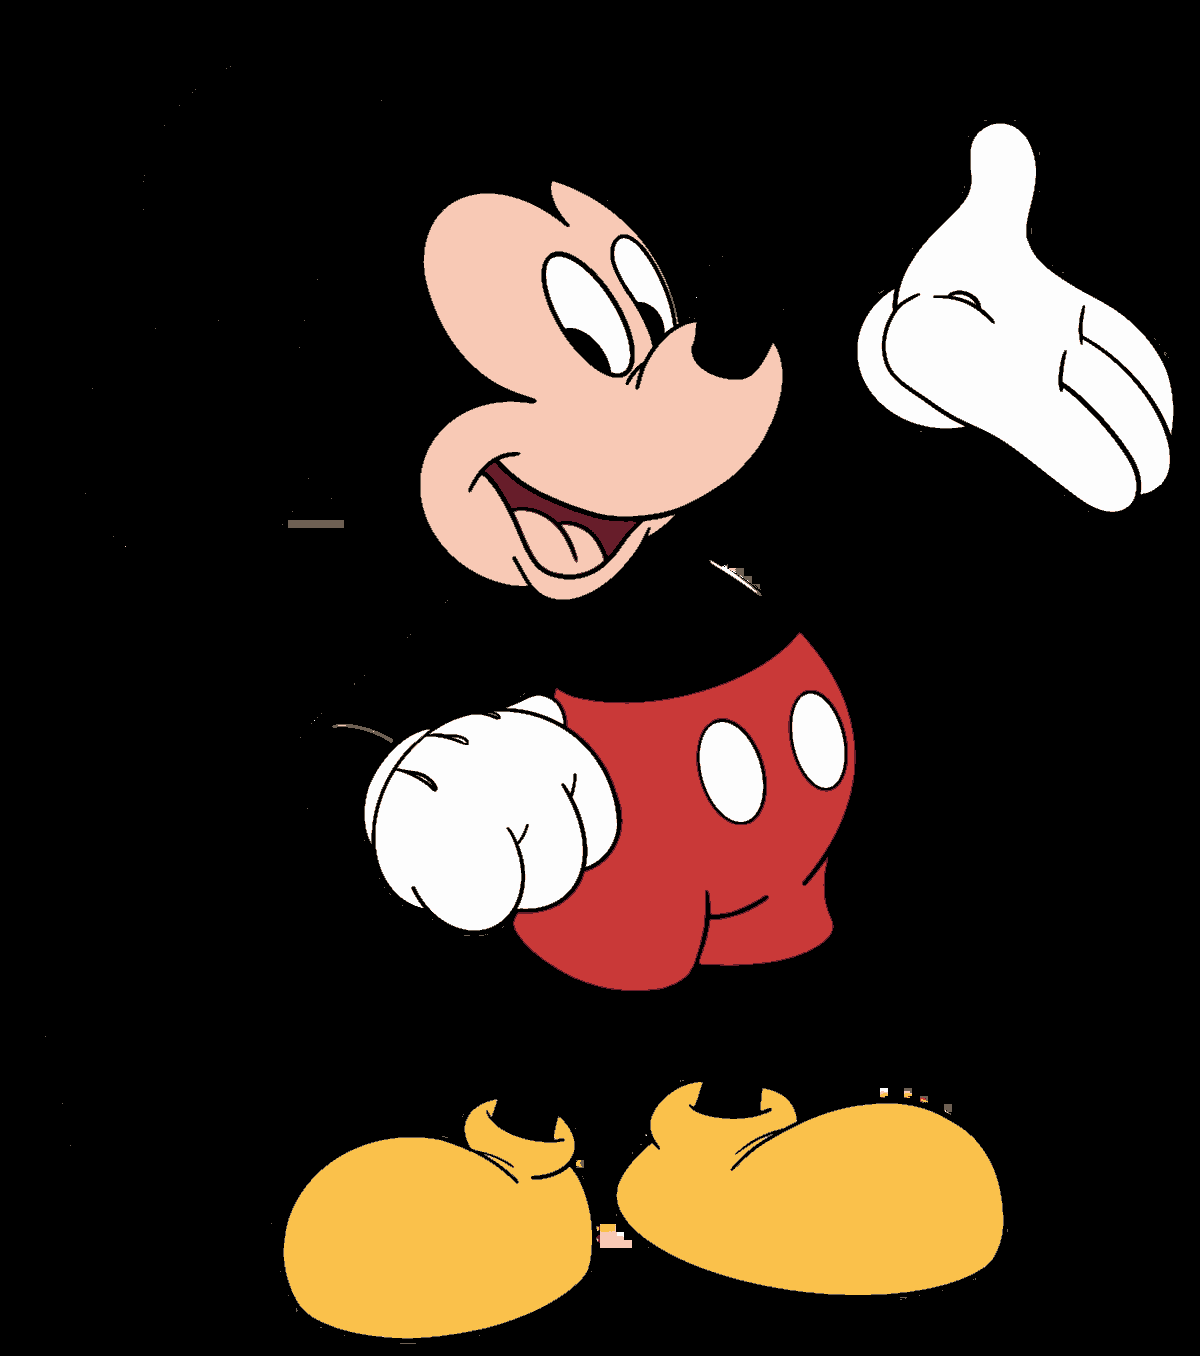


Image after removing regions < 1 pixels:


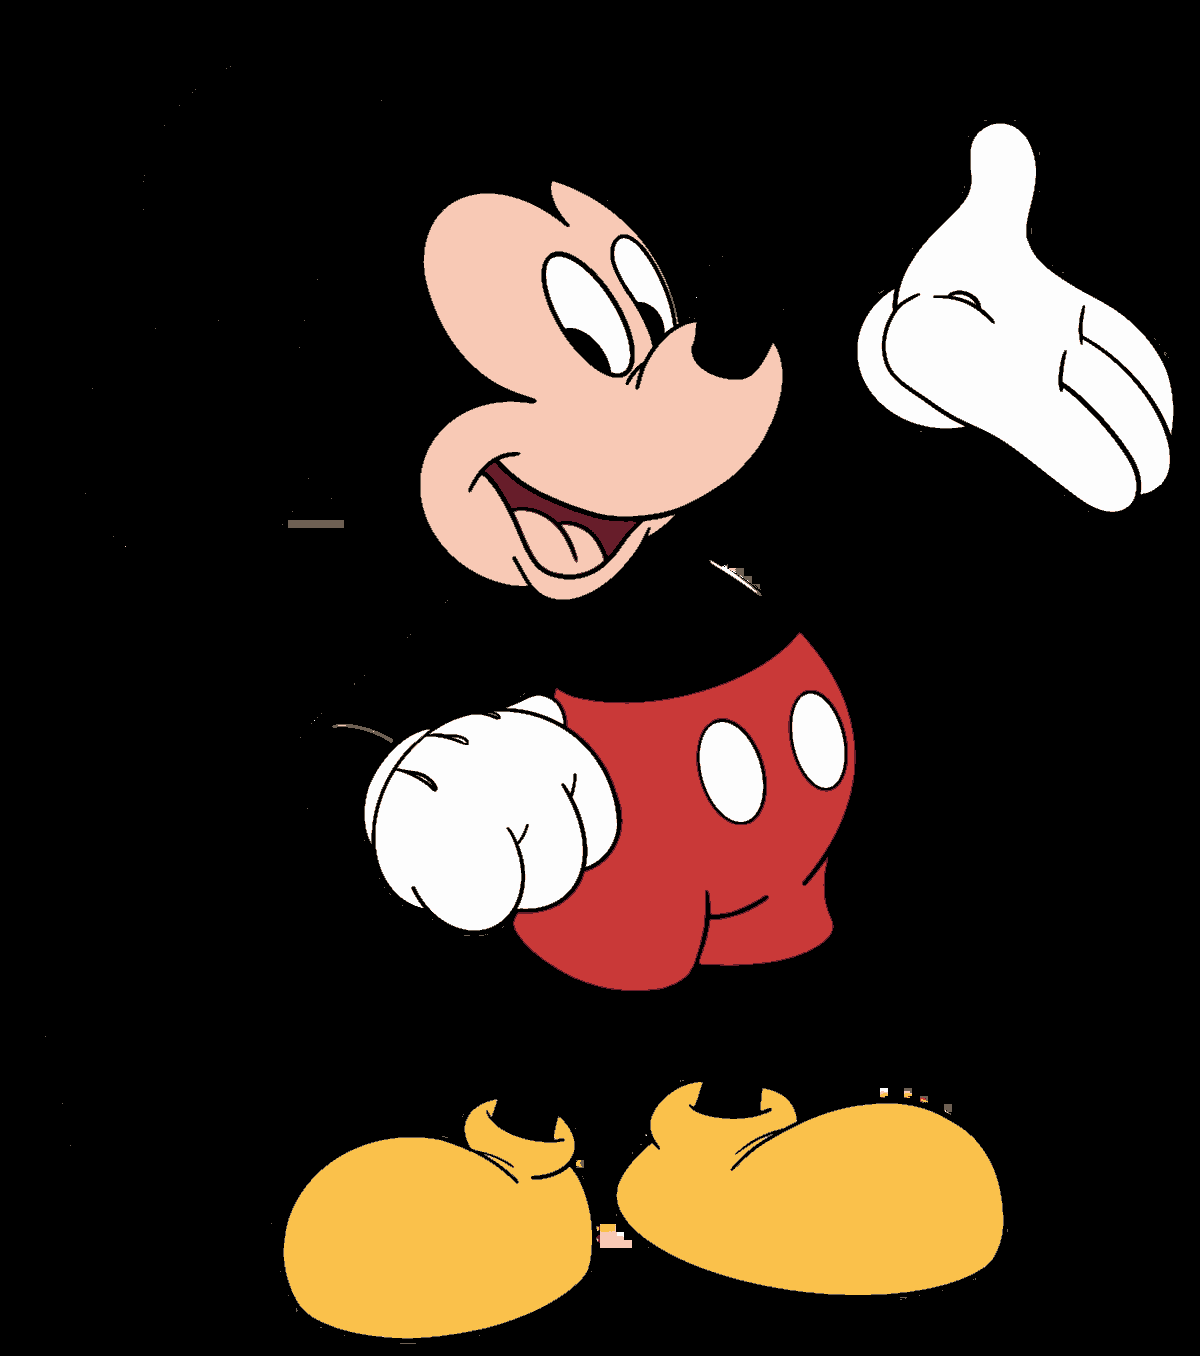

In [108]:
# --- User Input ---
area_threshold = 1 # <--- Set the minimum area for a region to be kept. Adjust this value.
# ------------------

image_to_clean = median_filtered_image


if image_to_clean is not None:
    print(f"\nRemoving minority pixels with area less than {area_threshold}...")
    cleaned_image = remove_minority_pixels(image_to_clean, area_threshold)

    if cleaned_image:
        print("Minority pixel removal complete.")
        print("\nOriginal Image (before removal):")
        display(image_to_clean)

        print(f"\nImage after removing regions < {area_threshold} pixels:")
        display(cleaned_image)

        # Optionally, save the cleaned image
        # output_image_path_cleaned = f"image_cleaned_threshold_{area_threshold}.png"
        # try:
        #     cleaned_image.save(output_image_path_cleaned)
        #     print(f"\nCleaned image saved to {output_image_path_cleaned}")
        # except Exception as e:
        #     print(f"  Error saving cleaned image: {e}")
    else:
        print("\nMinority pixel removal failed.")
else:
    print("No suitable image found to apply minority pixel removal. Please run previous cells.")

## new

In [ ]:
# CELL 1: Imports, Helper Functions, and Core Logic


# Imports and Helper Functions
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageOps
from skimage import color
from skimage.measure import label, regionprops
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.neighbors import NearestCentroid, NearestNeighbors
from collections import Counter
import io # For displaying images without saving
from IPython.display import display, HTML, Image as IPImage
import warnings

# Suppress specific warnings if needed (e.g., KMeans future warnings)
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn')

# Helper function to display PIL Images in Jupyter
def display_pil_image(img: Image.Image, title: str = None):
    """Displays a PIL image in Jupyter with an optional title."""
    if title:
        display(HTML(f'<h4>{title}</h4>'))
    display(img)

def display_rgb_palette(palette_rgb, title="Color Palette"):
    """
    Displays a horizontal bar of the given RGB colors.
    """
    if not palette_rgb:
        print("No palette to display.")
        return
    # Ensure palette colors are valid RGB tuples/lists
    valid_palette = [list(map(int, c)) for c in palette_rgb if len(c) == 3]
    if not valid_palette:
        print("Palette contains invalid color definitions.")
        return

    colors = np.array(valid_palette, dtype=np.uint8).reshape(1, -1, 3)
    # Create a simple PIL image for the palette
    palette_img = Image.fromarray(colors, 'RGB')
    # Scale up for visibility
    scale = 20
    palette_img = palette_img.resize((len(valid_palette) * scale, scale), Image.NEAREST)

    if title:
         display(HTML(f'<h5>{title} ({len(valid_palette)} colors)</h5>'))
    display(palette_img)

# %%
# Universal Quantization and Posterization

def quantize_with_alpha(img: Image.Image, num_colors: int, method) -> Image.Image:
    """
    Quantize an RGB or RGBA image to `num_colors` with PIL and preserve alpha if present.
    Uses Median Cut by default if method is not specified or invalid for RGBA directly.
    """
    if not (2 <= num_colors <= 256):
        raise ValueError("num_colors must be between 2 and 256.")

    has_alpha = img.mode in ("RGBA", "LA", "P") and 'A' in img.getbands()

    if has_alpha:
        # Separate alpha channel
        if img.mode != "RGBA":
             img_rgba = img.convert("RGBA")
        else:
             img_rgba = img
        alpha = img_rgba.getchannel("A")
        # Quantize the RGB part
        rgb = img_rgba.convert("RGB")
        # Use a robust method like MEDIANCUT or FASTOCTREE if original fails
        try:
            pal_img = rgb.quantize(colors=num_colors, method=method)
        except ValueError:
            print(f"Warning: Quantize method {method} might not be optimal. Trying MEDIANCUT.")
            pal_img = rgb.quantize(colors=num_colors, method=Image.Quantize.MEDIANCUT)

        # Convert palettized image back to RGBA and add original alpha
        pal_img_rgba = pal_img.convert("RGBA")
        pal_img_rgba.putalpha(alpha)
        # Extract palette from the P mode image for consistency
        palette = np.array(pal_img.getpalette()[:num_colors * 3]).reshape(-1, 3).tolist()
        return pal_img_rgba, palette
    else:
        # Image has no alpha, quantize directly
        rgb_img = img.convert("RGB")
        pal_img = rgb_img.quantize(colors=num_colors, method=method)
        palette = np.array(pal_img.getpalette()[:num_colors * 3]).reshape(-1, 3).tolist()
        return pal_img.convert("RGB"), palette # Return RGB for consistency


def posterize_with_palette(img: Image.Image, palette_rgb: list) -> Image.Image:
    """
    Remap the image colors to the given RGB palette, preserving transparency.
    Uses CIELAB color space for perceptually closer remapping.
    """
    if not palette_rgb:
         raise ValueError("Palette cannot be empty.")

    is_rgba = img.mode == "RGBA"
    if not is_rgba:
        img_rgba = img.convert("RGBA") # Work with RGBA internally
    else:
        img_rgba = img

    arr = np.array(img_rgba)
    h, w = arr.shape[:2]
    alpha = arr[..., 3]
    rgb = arr[..., :3]
    mask = alpha > 0  # Mask for non-transparent pixels

    # Only process non-transparent pixels
    rgb_masked = rgb[mask]
    if rgb_masked.size == 0: # Handle fully transparent image
        return img_rgba # Return original if no opaque pixels

    # Convert masked RGB pixels and palette to LAB
    # Avoid division by zero if max value is 0
    rgb_max = np.max(rgb_masked) if rgb_masked.size > 0 else 1.0
    lab_masked = color.rgb2lab(rgb_masked / 255.0 if rgb_max > 0 else rgb_masked)

    palette_arr = np.array(palette_rgb, dtype=np.uint8)
    palette_max = np.max(palette_arr) if palette_arr.size > 0 else 1.0
    palette_lab = color.rgb2lab(palette_arr / 255.0 if palette_max > 0 else palette_arr)

    # Use NearestCentroid to find the index of the closest palette color in LAB space
    clf = NearestCentroid().fit(palette_lab, np.arange(len(palette_lab)))
    idx = clf.predict(lab_masked)

    # Create the output RGBA array
    out_rgba = np.zeros_like(arr)
    out_rgba[..., 3] = alpha # Preserve original alpha

    # Assign the remapped colors only to non-transparent pixels
    out_rgba[mask, :3] = palette_arr[idx]

    return Image.fromarray(out_rgba, 'RGBA')

# %%
# CIELAB K-Means Quantization

def quantize_cielab_with_alpha(img: Image.Image, num_colors: int):
    """
    KMeans quantization in CIELAB space, preserving alpha.
    """
    if img.mode != "RGBA":
        img_rgba = img.convert("RGBA")
    else:
        img_rgba = img

    arr = np.array(img_rgba)
    h, w = arr.shape[:2]
    alpha = arr[..., 3]
    rgb = arr[..., :3]
    mask = alpha > 0 # Mask for non-transparent pixels

    # Only cluster non-transparent pixels
    rgb_masked = rgb[mask]
    if rgb_masked.size == 0: # Handle fully transparent image
        # Return a transparent image with an empty palette or default
        return img_rgba, []

    # Convert masked RGB pixels to LAB
    rgb_max = np.max(rgb_masked) if rgb_masked.size > 0 else 1.0
    lab_masked = color.rgb2lab(rgb_masked / 255.0 if rgb_max > 0 else rgb_masked)

    # Adjust k if number of unique colors is less than num_colors
    actual_num_colors = min(num_colors, len(np.unique(lab_masked, axis=0)))
    if actual_num_colors < 2: # Handle cases with 0 or 1 color
        if actual_num_colors == 1:
             centers_rgb = np.unique(rgb_masked, axis=0)
             out_rgba = np.zeros_like(arr)
             out_rgba[..., 3] = alpha
             out_rgba[mask, :3] = centers_rgb[0]
             return Image.fromarray(out_rgba, 'RGBA'), centers_rgb.tolist()
        else: # No opaque pixels
             return img_rgba, []


    # Perform KMeans clustering
    # Use 'auto' for n_init in newer scikit-learn, fallback to 10
    try:
         km = KMeans(n_clusters=actual_num_colors, random_state=42, n_init='auto')
    except ValueError:
         km = KMeans(n_clusters=actual_num_colors, random_state=42, n_init=10)

    labels = km.fit_predict(lab_masked)
    centers_lab = km.cluster_centers_

    # Convert cluster centers back to RGB
    centers_rgb = (color.lab2rgb(centers_lab.reshape(1, -1, 3))[0] * 255).clip(0, 255).astype(np.uint8)

    # Create the output RGBA array
    out_rgba = np.zeros_like(arr)
    out_rgba[..., 3] = alpha # Preserve original alpha

    # Assign cluster colors to the non-transparent pixels
    out_rgba[mask, :3] = centers_rgb[labels]

    return Image.fromarray(out_rgba, 'RGBA'), centers_rgb.tolist()


# %%
# MeanShift-based Palette Estimation

def reduce_palette_kmeans(initial_palette_lab: np.ndarray, target_colors: int) -> np.ndarray:
    """
    Reduce an LAB palette to `target_colors` via KMeans.
    """
    if initial_palette_lab is None or len(initial_palette_lab) <= target_colors:
        return initial_palette_lab

    actual_target = min(target_colors, len(initial_palette_lab))
    if actual_target < 1: return np.array([])

    try:
         kmeans = KMeans(n_clusters=actual_target, random_state=42, n_init='auto')
    except ValueError:
         kmeans = KMeans(n_clusters=actual_target, random_state=42, n_init=10)

    kmeans.fit(initial_palette_lab)
    return kmeans.cluster_centers_


def mean_shift_quantize(img: Image.Image,
                        downsample_factor: float = 0.25,
                        bandwidth_quantile: float = 0.2,
                        bandwidth_samples_pct: float = 0.20, # % -> float 0-100
                        desired_colors: int = 8):
    """
    Estimate a palette via MeanShift on a downsampled version (considering only opaque pixels),
    reduce palette via KMeans, and reconstruct full-res image preserving alpha.
    """
    if img.mode != "RGBA":
        orig_rgba = img.convert("RGBA")
    else:
        orig_rgba = img

    arr_rgba = np.array(orig_rgba)
    h, w = arr_rgba.shape[:2]
    alpha = arr_rgba[..., 3]
    rgb_full = arr_rgba[..., :3]
    mask_full = alpha > 0

    if not np.any(mask_full): # Handle fully transparent image
        return orig_rgba, []

    # Downsample for MeanShift bandwidth estimation and clustering
    # Use ANTIALIAS for better downsampling quality
    ds_w = max(1, int(w * downsample_factor))
    ds_h = max(1, int(h * downsample_factor))
    ds_img = orig_rgba.resize((ds_w, ds_h), resample=Image.Resampling.LANCZOS) # Use LANCZOS/ANTIALIAS
    ds_arr = np.array(ds_img)
    ds_alpha = ds_arr[..., 3]
    ds_rgb = ds_arr[..., :3]
    ds_mask = ds_alpha > 128 # Consider pixels > 50% opaque for clustering

    # Extract non-transparent pixels from downsampled image for clustering
    ds_rgb_masked = ds_rgb[ds_mask]
    if ds_rgb_masked.size == 0: # No opaque pixels in downsampled
         print("Warning: No opaque pixels found after downsampling for MeanShift.")
         # Fallback: attempt quantization on original opaque pixels if any exist
         rgb_full_masked = rgb_full[mask_full]
         if rgb_full_masked.size == 0: return orig_rgba, [] # Still no opaque pixels
         lab_full_masked = color.rgb2lab(rgb_full_masked / 255.0)
         n_unique_full = len(np.unique(lab_full_masked, axis=0))
         if n_unique_full == 0: return orig_rgba, []
         actual_colors = min(desired_colors, n_unique_full)
         if actual_colors < 1: return orig_rgba, []
         try:
              km = KMeans(n_clusters=actual_colors, random_state=42, n_init='auto')
         except ValueError:
              km = KMeans(n_clusters=actual_colors, random_state=42, n_init=10)
         km.fit(lab_full_masked)
         palette_lab = km.cluster_centers_

    else:
        # Convert masked downsampled RGB to LAB
        ds_lab_masked = color.rgb2lab(ds_rgb_masked / 255.0)

        # Estimate bandwidth on a subset of the masked downsampled LAB pixels
        n_total_pixels_ds = ds_lab_masked.shape[0]
        n_samples = max(100, min(n_total_pixels_ds, int(n_total_pixels_ds * (bandwidth_samples_pct / 100.0))))
        if n_samples < ds_lab_masked.shape[0]:
            sample_indices = np.random.choice(ds_lab_masked.shape[0], n_samples, replace=False)
            pixels_for_bw = ds_lab_masked[sample_indices]
        else:
            pixels_for_bw = ds_lab_masked

        # Handle cases with very few pixels for bandwidth estimation
        if pixels_for_bw.shape[0] < 2:
            bw = 1.0 # Default bandwidth if too few samples
            print("Warning: Too few samples for bandwidth estimation, using default.")
        else:
           try:
               bw = estimate_bandwidth(pixels_for_bw, quantile=bandwidth_quantile,
                                        n_samples=min(n_samples, pixels_for_bw.shape[0]), # Ensure n_samples <= actual samples
                                        random_state=42)
               # Ensure bandwidth is positive
               bw = max(bw, 0.1) if bw is not None else 1.0 # Set minimum bandwidth or default
           except Exception as e:
               print(f"Warning: Bandwidth estimation failed ({e}), using default bandwidth=1.0")
               bw = 1.0


        # Perform MeanShift clustering on all masked downsampled LAB pixels
        ms = MeanShift(bandwidth=bw, cluster_all=False, n_jobs=-1, max_iter=100) # Limit iterations
        ms.fit(ds_lab_masked)
        palette_lab = ms.cluster_centers_

        # Reduce palette to desired number of colors using KMeans if needed
        if len(palette_lab) > desired_colors:
            palette_lab = reduce_palette_kmeans(palette_lab, desired_colors)

    if palette_lab is None or len(palette_lab) == 0:
        print("Warning: MeanShift resulted in an empty palette. Returning original image.")
        return orig_rgba, []

    # Convert final palette back to RGB
    reduced_rgb = (color.lab2rgb(palette_lab.reshape(1, -1, 3))[0] * 255).clip(0, 255).astype(np.uint8)

    # Map original full-resolution non-transparent pixels to the reduced palette using NearestNeighbors in LAB space
    lab_full_masked = color.rgb2lab(rgb_full[mask_full] / 255.0)

    nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(palette_lab)
    _, idx = nn.kneighbors(lab_full_masked)

    # Create the output RGBA array
    out_rgba = np.zeros_like(arr_rgba)
    out_rgba[..., 3] = alpha # Preserve original alpha

    # Assign the mapped colors from the reduced palette to the non-transparent pixels
    out_rgba[mask_full, :3] = reduced_rgb[idx.flatten()]

    return Image.fromarray(out_rgba, 'RGBA'), reduced_rgb.tolist()


# %%
# Median Filtering and Minority Pixel Removal (Preserving Alpha)

def apply_median_filter_and_remap(image: Image.Image, size: int, original_palette_rgb: list) -> Image.Image:
    """
    Applies a median filter to the RGB channels of an RGBA image,
    preserves the original alpha channel, and remaps colors back to the
    original palette using NearestCentroid in LAB space on non-transparent pixels.
    """
    if image.mode != 'RGBA':
        image = image.convert('RGBA')
    if not original_palette_rgb:
        print("Warning: Cannot remap without a palette. Returning filtered image without remapping.")
        # Apply filter and return
        rgb = image.convert('RGB').filter(ImageFilter.MedianFilter(size=size))
        rgba_out = Image.merge('RGBA', (*rgb.split(), image.getchannel('A')))
        return rgba_out

    arr_rgba = np.array(image)
    alpha = arr_rgba[..., 3]
    rgb = arr_rgba[..., :3]
    mask = alpha > 0

    # Apply median filter only to RGB channels
    pil_rgb = Image.fromarray(rgb, 'RGB')
    filtered_pil_rgb = pil_rgb.filter(ImageFilter.MedianFilter(size=size))
    filtered_rgb = np.array(filtered_pil_rgb)

    # Remap filtered non-transparent pixels back to the original palette
    rgb_masked = filtered_rgb[mask]
    if rgb_masked.size == 0: # Handle fully transparent or masked image
        out_rgba = np.dstack([filtered_rgb, alpha])
        return Image.fromarray(out_rgba, 'RGBA')

    # Convert masked RGB and palette to LAB
    lab_masked = color.rgb2lab(rgb_masked / 255.0)
    palette_arr = np.array(original_palette_rgb, dtype=np.uint8)
    palette_lab = color.rgb2lab(palette_arr / 255.0)

    # Use NearestCentroid to map back to the palette
    clf = NearestCentroid().fit(palette_lab, np.arange(len(palette_lab)))
    idx = clf.predict(lab_masked)

    # Create remapped RGB array
    remapped_rgb = np.zeros_like(rgb)
    remapped_rgb[mask] = palette_arr[idx]

    # Combine remapped RGB with original alpha
    out_rgba = np.dstack([remapped_rgb, alpha])

    # Debug unique counts
    unique_before = len(np.unique(arr_rgba[mask,:3].reshape(-1, 3), axis=0)) if np.any(mask) else 0
    unique_after = len(np.unique(remapped_rgb[mask].reshape(-1, 3), axis=0)) if np.any(mask) else 0
    print(f"Unique colors before filter/remap (opaque): {unique_before}")
    print(f"Unique colors after filter/remap (opaque): {unique_after}")

    return Image.fromarray(out_rgba, 'RGBA')


def remove_minority_pixels(image: Image.Image, area_threshold: int) -> Image.Image:
    """
    Removes small connected components below a given pixel area threshold
    in an RGBA image, replacing them with the most frequent neighboring *opaque* color,
    preserving transparency.
    """
    if image.mode != 'RGBA':
        image = image.convert('RGBA')

    arr = np.array(image)
    h, w = arr.shape[:2]
    alpha = arr[..., 3]
    rgb = arr[..., :3]
    cleaned_rgb = rgb.copy() # Work on RGB, preserve alpha separately

    # Define neighbor offsets (8-connectivity)
    neighbor_offsets = [
        (-1, -1), (-1, 0), (-1, 1),
        (0, -1),          (0, 1),
        (1, -1), (1, 0), (1, 1)
    ]

    # Process each unique *opaque* color separately
    opaque_mask = alpha > 0
    if not np.any(opaque_mask): # Handle fully transparent image
        return image

    # Get unique opaque colors and their integer representation for labeling
    unique_colors_rgb = np.unique(rgb[opaque_mask].reshape(-1, 3), axis=0)

    # Create an integer map of the opaque pixels for labeling
    # Assign a unique integer to each unique opaque color
    color_to_int = {tuple(c): i + 1 for i, c in enumerate(unique_colors_rgb)}
    int_map = np.zeros((h, w), dtype=np.int32)
    for color_val, int_val in color_to_int.items():
         color_mask = np.all(rgb == color_val, axis=2) & opaque_mask
         int_map[color_mask] = int_val

    # Label connected components on the integer map
    lbl = label(int_map, connectivity=2, background=0) # background=0 for transparent/unassigned
    regs = regionprops(lbl)

    pixels_replaced_count = 0
    # Iterate through regions and clean small ones
    for reg in regs:
        if reg.area < area_threshold:
            # Get the color of the current small region (use the first pixel)
            r_reg, c_reg = reg.coords[0]
            region_color_int = lbl[r_reg, c_reg] # Get the label value which corresponds to the region

            # Find neighbors *outside* this region but *within* the opaque area
            neighbor_colors = []
            for r, c in reg.coords:
                for dr, dc in neighbor_offsets:
                    nr, nc = r + dr, c + dc
                    # Check bounds, ensure neighbor is opaque, and not part of the same small region
                    if (0 <= nr < h and 0 <= nc < w and
                        alpha[nr, nc] > 0 and # Check if neighbor is opaque
                        lbl[nr, nc] != region_color_int): # Check if it's a different region/color
                        neighbor_colors.append(tuple(rgb[nr, nc]))

            if neighbor_colors:
                # Choose the most common *opaque* neighbor color
                fill_color = Counter(neighbor_colors).most_common(1)[0][0]
                fill_color_arr = np.array(fill_color, dtype=np.uint8)
                # Fill the small region with this color in the cleaned_rgb array
                for r, c in reg.coords:
                    cleaned_rgb[r, c] = fill_color_arr
                pixels_replaced_count += reg.area

    if pixels_replaced_count > 0:
        print(f"Removed {pixels_replaced_count} pixels from small regions.")
    else:
        print("No small regions found or replaced.")

    # Combine cleaned RGB with original alpha
    cleaned_rgba = np.dstack([cleaned_rgb, alpha])
    return Image.fromarray(cleaned_rgba, 'RGBA')

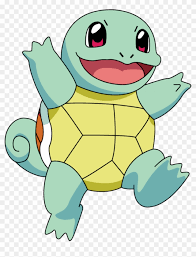

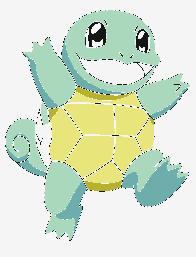

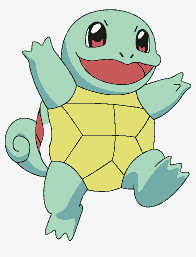

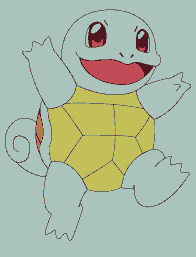

Unique colors before filter/remap (opaque): 7
Unique colors after filter/remap (opaque): 7


C:\Users\adamk\AppData\Roaming\Python\Python313\site-packages\sklearn\neighbors\_nearest_centroid.py:241: RuntimeWarning: invalid value encountered in divide
  np.sqrt(variance.sum(axis=0) / (n_samples - n_classes)), copy=False


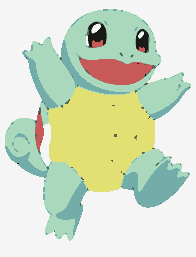

Removed 576.0 pixels from small regions.


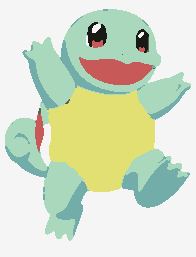

C:\Users\adamk\AppData\Roaming\Python\Python313\site-packages\sklearn\neighbors\_nearest_centroid.py:241: RuntimeWarning: invalid value encountered in divide
  np.sqrt(variance.sum(axis=0) / (n_samples - n_classes)), copy=False


Unique colors before filter/remap (opaque): 7
Unique colors after filter/remap (opaque): 7


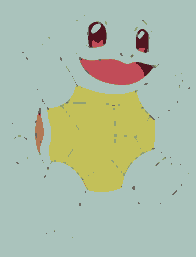

Removed 593.0 pixels from small regions.


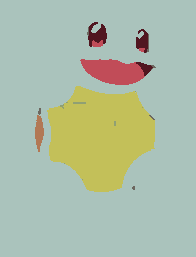

In [148]:
# CELL 2: Execution and Display

# User settings
image_path = 'squirtle.png' #<-- CHANGE THIS TO YOUR IMAGE PATH

num_colors = 7       # Target number of colors for initial quantization
method = Image.Quantize.FASTOCTREE # PIL quantization method
ds_factor = 0.2     # Downsampling factor for MeanShift (e.g., 0.25 = 1/4 size)
bw_quantile = 0.1    # Quantile for MeanShift bandwidth estimation
bw_samples_pct = 0.2 # Percentage of downsampled pixels for bandwidth estimation
final_colors = 7     # Target number of colors for MeanShift final palette
median_size = 3      # Size of the median filter kernel (e.g., 3 for 3x3)
area_thresh = 10     # Minimum pixel area for connected components to keep


# --- Image Loading ---
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image file not found at: {image_path}")

img = Image.open(image_path)
# Ensure image is in RGBA format for consistency
if img.mode != 'RGBA':
    img = img.convert('RGBA')

display_pil_image(img, "Original Image")

# --- 1. PIL Quantize (using quantize_with_alpha) ---
display(HTML("<hr><h2>Method 1: PIL Quantization (Fast Octree)</h2>"))
try:
    pil_quantized, pil_palette = quantize_with_alpha(img, num_colors, method)
    display_pil_image(pil_quantized, f"PIL Quantized ({num_colors} colors)")
    display_rgb_palette(pil_palette, 'PIL Palette')

    # Optional: Posterize original image with this palette
    # pil_posterized = posterize_with_palette(img, pil_palette)
    # display_pil_image(pil_posterized, "Original Posterized with PIL Palette")

except Exception as e:
    print(f"Error during PIL Quantization: {e}")
    pil_quantized, pil_palette = None, [] # Set defaults for potential later steps

# --- 2. CIELAB K-Means Quantization ---
display(HTML("<hr><h2>Method 2: CIELAB K-Means Quantization</h2>"))
try:
    kmeans_quantized, kmeans_palette = quantize_cielab_with_alpha(img, num_colors)
    display_pil_image(kmeans_quantized, f"CIELAB K-Means Quantized ({len(kmeans_palette)} colors)")
    display_rgb_palette(kmeans_palette, 'CIELAB K-Means Palette')

    # Optional: Posterize original image with this palette
    # kmeans_posterized = posterize_with_palette(img, kmeans_palette)
    # display_pil_image(kmeans_posterized, "Original Posterized with K-Means Palette")

except Exception as e:
    print(f"Error during CIELAB K-Means Quantization: {e}")
    kmeans_quantized, kmeans_palette = None, [] # Set defaults

# --- 3. MeanShift Quantization ---
display(HTML("<hr><h2>Method 3: MeanShift Quantization</h2>"))
try:
    ms_quantized, ms_palette = mean_shift_quantize(img, ds_factor, bw_quantile, bw_samples_pct, final_colors)
    display_pil_image(ms_quantized, f"MeanShift Quantized ({len(ms_palette)} colors)")
    display_rgb_palette(ms_palette, 'MeanShift Palette')

    # Optional: Posterize original image with this palette
    # ms_posterized = posterize_with_palette(img, ms_palette)
    # display_pil_image(ms_posterized, "Original Posterized with MeanShift Palette")

except Exception as e:
    print(f"Error during MeanShift Quantization: {e}")
    ms_quantized, ms_palette = None, [] # Set defaults

# --- 4. Post-processing (Example using K-Means result) ---
# You can choose which quantized image and palette to use here (e.g., ms_quantized, ms_palette)
# Using K-Means result as an example:
display(HTML("<hr><h2>Post-processing (Applied to K-Means Result)</h2>"))
if kmeans_quantized and kmeans_palette:
    # Apply Median Filter + Remap
    display(HTML("<h3>Step 4a: Median Filtering & Remapping</h3>"))
    try:
        median_filtered = apply_median_filter_and_remap(kmeans_quantized, median_size, kmeans_palette)
        display_pil_image(median_filtered, f"Median Filtered (Size={median_size}) & Remapped")

        # Apply Minority Pixel Removal
        display(HTML("<h3>Step 4b: Minority Pixel Removal</h3>"))
        try:
            cleaned_image = remove_minority_pixels(median_filtered, area_thresh)
            display_pil_image(cleaned_image, f"Minority Pixels Removed (Threshold={area_thresh}) - Final")
        except Exception as e:
            print(f"Error during Minority Pixel Removal: {e}")

    except Exception as e:
        print(f"Error during Median Filtering/Remapping: {e}")
else:
    print("Skipping post-processing as the K-Means result is not available.")

# --- 5. Post-processing (Example using MeanShift result) ---
display(HTML("<hr><h2>Post-processing (Applied to MeanShift Result)</h2>"))
if ms_quantized and ms_palette:
    # Apply Median Filter + Remap
    display(HTML("<h3>Step 5a: Median Filtering & Remapping</h3>"))
    try:
        median_filtered_ms = apply_median_filter_and_remap(ms_quantized, median_size, ms_palette)
        display_pil_image(median_filtered_ms, f"Median Filtered (Size={median_size}) & Remapped")

        # Apply Minority Pixel Removal
        display(HTML("<h3>Step 5b: Minority Pixel Removal</h3>"))
        try:
            cleaned_image_ms = remove_minority_pixels(median_filtered_ms, area_thresh)
            display_pil_image(cleaned_image_ms, f"Minority Pixels Removed (Threshold={area_thresh}) - Final")
        except Exception as e:
            print(f"Error during Minority Pixel Removal: {e}")

    except Exception as e:
        print(f"Error during Median Filtering/Remapping: {e}")
else:
    print("Skipping post-processing as the MeanShift result is not available.")